In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from preprocessing import filter_country, colnames_generator, Create_TrainTest
from prediction import evaluate, onestep_prediction, multistep_prediction, plot

from keras.models import Model
from keras.layers import Input, Dense, LSTM, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint

In [2]:
df = pd.read_csv('../Data/Covid19_Data.csv', index_col=0, parse_dates=['Date']).set_index('Date')

X, y, indx = filter_country(df=df, 
                            country='England', 
                            start_time=None, 
                            end_time=None, 
                            outcome='PredictionRatio')

X_train, X_test, y_train, y_test, train_indx, test_indx = Create_TrainTest(X = X, 
                                                                           y = y,
                                                                           method='single', 
                                                                           indx=indx, 
                                                                           T=10, 
                                                                           n_test=7)

In [3]:
X_train = X_train.reshape(-1, 10, 10)
X_test = X_test.reshape(-1, 10, 10) 

In [4]:
M = 20  # hidden vector size (number of nodes)

i = Input(shape=(10, 10))
x = LSTM(50)(i)
x = Dense(1)(x)

lstm = Model(i, x)

In [36]:
lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 10)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
15/15 [==============================] - 5s 73ms/step - loss: 0.3362 - val_loss: 0.1826
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0386 - val_loss: 0.0185
Epoch 3/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0125 - val_loss: 0.0148
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 5/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 6/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 0.0035

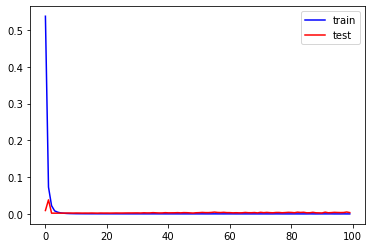

In [38]:
plt.plot(lstm.history.history['loss'], color='blue', label='train')
plt.plot(lstm.history.history['val_loss'], color='red', label='test')

plt.legend()

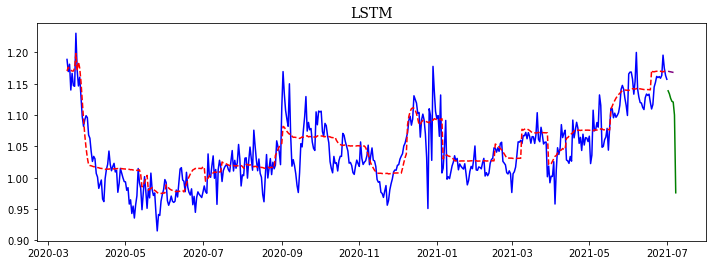

In [13]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = lstm.predict(X_train).clip(0), 
     pred_test = lstm.predict(X_test).clip(0), 
     name = 'LSTM')

### Multi-output

In [5]:
X_train_M, X_test_M, y_train_M, y_test_M, train_indx_M, test_indx_M = Create_TrainTest(X = X, 
                                                                                       y = y,
                                                                                       method='multi', 
                                                                                       indx=indx, 
                                                                                       T=10, 
                                                                                       n_test=7)

X_train_M = X_train_M.reshape(-1, 10, 10)
X_test_M = X_test_M.reshape(-1, 10, 10)

In [6]:
M = 20  # hidden vector size (number of nodes)

i = Input(shape=(10, 10))
x = LSTM(50, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)   # optional
x = Dense(7)(x)

lstm_multi = Model(i, x)

In [7]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [8]:
lstm_multi.compile(loss='mse', optimizer='adam')

lstm_multi.fit(X_train_M, y_train_M, epochs=10, validation_data=(X_test_M, y_test_M), callbacks=[check_point])

Epoch 1/10
15/15 [==============================] - 5s 75ms/step - loss: 0.5084 - val_loss: 0.1526
Epoch 2/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0537 - val_loss: 0.0134
Epoch 3/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0237 - val_loss: 0.0048
Epoch 4/10
15/15 [==============================] - 0s 14ms/step - loss: 0.0123 - val_loss: 0.0092
Epoch 5/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 6/10
15/15 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 7/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 8/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 9/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 10/10
15/15 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 0.0019


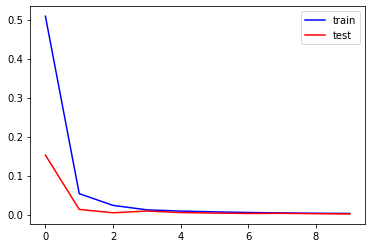

In [9]:
plt.plot(lstm_multi.history.history['loss'], color='blue', label='train')
plt.plot(lstm_multi.history.history['val_loss'], color='red', label='test')

plt.legend()

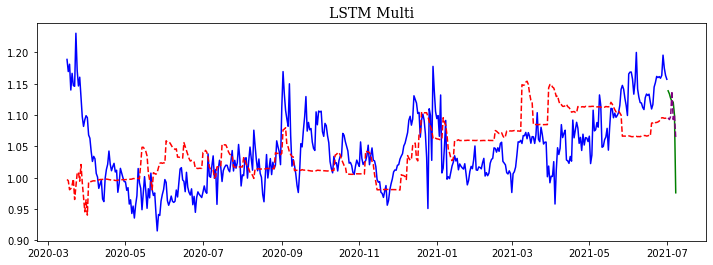

In [11]:
plot(train_indx, y_train, test_indx, y_test, 
     pred_train = lstm_multi.predict(X_train_M).clip(0)[:,0], 
     pred_test = lstm_multi.predict(X_test_M).clip(0).reshape(-1), 
     name = 'LSTM Multi')